# **Predicting Concrete Compressive Strength**

### Motivation:
Concrete is a fundamental material in civil engineering. Its compressive strength is important for ensuring the safety and durability of structures. However, determining this strength accurately is challenging because it depends on a nonlinear function between several factors, including the age of the concrete and the proportions of its components—such as cement, blast furnace slag, fly ash, water, superplasticizer, coarse aggregate, and fine aggregate.
This project aims to apply machine learning techniques to improve the prediction of concrete strength, in order to contribute to better design, quality control, and resource optimization in construction.

### Dataset Explanation:
The dataset is sourced from the UCI Machine Learning Repository and contains 1030 observations with 8 quantitative input variables, and 1 quantitative output variable.
The input variables are: cement, blast furnace slag, fly ash, water, superplasticizer, coarse aggregate, fine aggregate and age. Except for age, the other variables are ingredient quantities in the concrete mixture and measured in *kg in a $m^{3}$* mixture. The age is measured in *days*.
The target, concrete compressive strengt, is measured in *MPa*.

### Data Analytics: Preprocessing
Since there is no missing attribute values according to the information provided by UCI Machine Learning Repository. Data can be directly read from Concrete_data.csv. 

In [29]:
import statsmodels.api as sm
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
import sklearn

from matplotlib import pyplot as plt
from pandas.plotting import scatter_matrix
from itertools import combinations
from IPython.display import display, Math

from statsmodels.stats.outliers_influence import OLSInfluence
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, make_scorer, r2_score

from sklearn.model_selection import KFold, cross_validate

%matplotlib inline
plt.style.use('ggplot') 
sns.set_style("darkgrid")
# print numpy arrays with precision 4
np.set_printoptions(precision=4)

In [30]:
concrete_df = pd.read_csv('./Concrete_data.csv', 
                          sep = ';',
                         decimal = ',',
                         encoding = 'UTF-8')
concrete_df.columns = concrete_df.columns.str.strip()
concrete_df.head()

,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day),"Concrete compressive strength(MPa, megapascals)"
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In [31]:

print("Original data types：")
print(concrete_df.dtypes)

# object to numeric
for col in concrete_df.columns:
    if concrete_df[col].dtype == 'object':
        concrete_df[col] = pd.to_numeric(concrete_df[col], errors='coerce')


print("\nTransfromed datatypes：")
print(concrete_df.dtypes)

# NaN 
print("\nRows with NaN：", concrete_df.isna().sum().sum())

# Drop NaN
concrete_df = concrete_df.dropna()

Original data types：
Cement (component 1)(kg in a m^3 mixture)                float64
Blast Furnace Slag (component 2)(kg in a m^3 mixture)    float64
Fly Ash (component 3)(kg in a m^3 mixture)               float64
Water  (component 4)(kg in a m^3 mixture)                float64
Superplasticizer (component 5)(kg in a m^3 mixture)      float64
Coarse Aggregate  (component 6)(kg in a m^3 mixture)     float64
Fine Aggregate (component 7)(kg in a m^3 mixture)        float64
Age (day)                                                  int64
Concrete compressive strength(MPa, megapascals)          float64
dtype: object

Transfromed datatypes：
Cement (component 1)(kg in a m^3 mixture)                float64
Blast Furnace Slag (component 2)(kg in a m^3 mixture)    float64
Fly Ash (component 3)(kg in a m^3 mixture)               float64
Water  (component 4)(kg in a m^3 mixture)                float64
Superplasticizer (component 5)(kg in a m^3 mixture)      float64
Coarse Aggregate  (component 6)

In [32]:
#define all the variables we need for the linear regression with concrete compressive strength as response and all other variables as possible features
label_column = 'Concrete compressive strength(MPa, megapascals)'
feature_columns = [c for c in concrete_df.columns if c != label_column]
X = concrete_df[feature_columns].values
y = concrete_df[label_column].values
p = len(feature_columns)
print("Features are:", feature_columns,
      ", and the response variable is:", label_column)

Features are: ['Cement (component 1)(kg in a m^3 mixture)', 'Blast Furnace Slag (component 2)(kg in a m^3 mixture)', 'Fly Ash (component 3)(kg in a m^3 mixture)', 'Water  (component 4)(kg in a m^3 mixture)', 'Superplasticizer (component 5)(kg in a m^3 mixture)', 'Coarse Aggregate  (component 6)(kg in a m^3 mixture)', 'Fine Aggregate (component 7)(kg in a m^3 mixture)', 'Age (day)'] , and the response variable is: Concrete compressive strength(MPa, megapascals)


#### Explanation of relevant variables:

The following table shows the meaning and expected effect of respective variables on strength. 
| Variable             | Meaning                              | Expected Effect on Strength    |
| -------------------- | ------------------------------------ | ------------------------------ |
| `cement`             | Binder                               | increases strength          |
| `blast_furnace_slag` | Supplementary binder                 | increases strength or neutral                  |
| `fly_ash`            | Supplementary binder                 | increase strength or neutral                  |
| `water`              | Affects workability and hydration    | decreases strength (excess) |
| `superplasticizer`   | Increases workability, reduces water | increase or decrease depending on context  |
| `coarse_aggregate`   | Filler                               | neutral or mild effect         |
| `fine_aggregate`     | Filler                               | neutral or mild effect         |
| `age`                | Curing time                          | increases strength          |


#### Feature scaling

In [33]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled

array([[ 2.4779, -0.8569, -0.8471, ...,  0.8632, -1.2177, -0.2797],
       [ 2.4779, -0.8569, -0.8471, ...,  1.0562, -1.2177, -0.2797],
       [ 0.4914,  0.7955, -0.8471, ..., -0.5265, -2.2409,  3.5531],
       ...,
       [-1.2701,  0.7596,  0.8506, ..., -1.0361,  0.0801, -0.2797],
       [-1.1686,  1.3081, -0.8471, ...,  0.2146,  0.1912, -0.2797],
       [-0.194 ,  0.3085,  0.3769, ..., -1.3951, -0.1507, -0.2797]])

#### Distribution of target variable

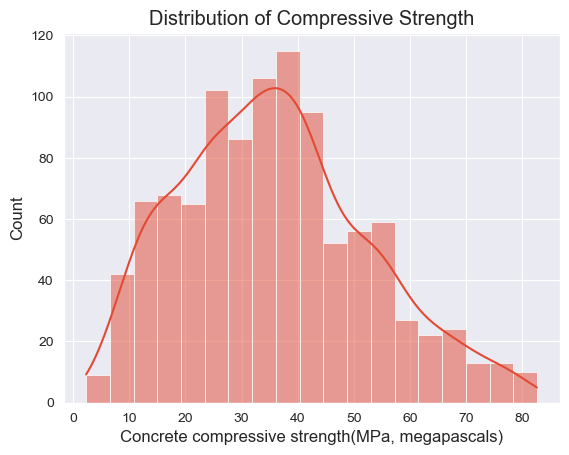

In [34]:
sns.histplot(concrete_df[label_column], kde=True)
plt.title("Distribution of Compressive Strength")
plt.show()

The sns.histplot clearly illustrates that the compressive strength data is not uniformly or normally distributed. Instead, it shows a sporadic and spread-out distribution with many unique or rarely occurring strength values, and potentially some concentrations at the extreme ends of the
measured range.
The data distribution is sparsity, lack of strong central Tendency, so we need to avoid assumption-heavy models (Simple linear regression) and consider robust models (Decision-tree is expected performing the best).
It doesn’t means that we don’t try simple linear regression, but maybe it can tell why linear regression doesn’t perform well

#### Correlation between relevant variables:

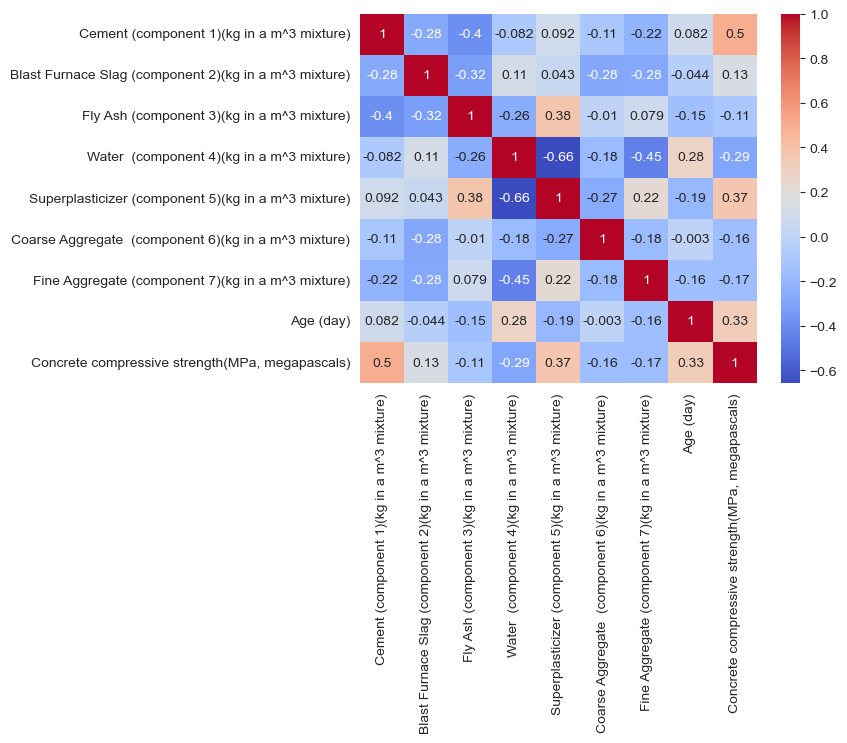

In [35]:
corr = concrete_df.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.show()

#### Variables that influence concrete strength:

According to the result of the heatmap, it can be seen that **cement** has a moderately strong positive correlation with concrete strength with a value of +0.50, which indicates more cement usually leads to stronger concrete. **Superplasticizer** also has a positive effect with a value of +0.37.
**Age** has a positive effect too , because concrete gets stronger over time.
**Water** has a negative correlation with strength of -0.29, which means more water tends to weaken concrete. This observation is consistent with **Abrams' water-to-cement ratio pronouncement**, which emphasizes that increased water relative to cement typically reduces concrete strength.

#### Multicollinearity:

The highest multicollinearity is the correlation between **water and superplasticizer**, which has a value of -0.66. This indicates they carry overlapping and opposite information. There is also moderate correlation among **cement**, **blast furnace slag**, and **fly ash** because these may act as partial substitutes in the concrete mix, so they tend to move in opposite directions. 

In [36]:
VIFs = [(predictor, variance_inflation_factor(X,_)) \
        for _,predictor in enumerate(list(feature_columns))] 
print('Variance Inflation Factors')
for tup in VIFs:
    print('{:20}'.format(tup[0]), '{:.3f}'.format(tup[1]))

Variance Inflation Factors
Cement (component 1)(kg in a m^3 mixture) 15.457
Blast Furnace Slag (component 2)(kg in a m^3 mixture) 3.329
Fly Ash (component 3)(kg in a m^3 mixture) 4.148
Water  (component 4)(kg in a m^3 mixture) 82.158
Superplasticizer (component 5)(kg in a m^3 mixture) 5.471
Coarse Aggregate  (component 6)(kg in a m^3 mixture) 84.956
Fine Aggregate (component 7)(kg in a m^3 mixture) 72.791
Age (day)            1.699


The variance inflation factors are larger for cement, blast furnace slag, fly ash, water, coarse aggregate, fine aggregate. This also indicates multi-collinearity of the factors mention above.

As mentioned in the lecture content of Machine Learning and Data Analytics(MLDA), VIF equal to 1 shows the absence of collinearity Usually, there is collinearity when VIF is larger than 5.

### Machine Learning Methods:
This project aims to predict concrete compressive strength which is a problem with a quantitative response. According to the lecture content in the fundamental part of MLDA, this task is a **regression task**. In the following part, linear regression, ridge regression, lasso regression, one decision-tree based method are applied. 

### Cross validation:

#### K-fold cross validation:

For supervised machine learning, the goal is to develop a model that can perform accurately not only on the data it was trained on, but also on previously unseen data. To evaluate a model's generalization ability, the **K-fold** method is utilized as the cross validation method.

In [37]:
# define the kfold, shuffle the training and test dataset every time
kf = KFold(n_splits=10, random_state = 0, shuffle = True)

##### Scorers for the model

In [38]:
# Create MSE scorer 
mse_scorer = make_scorer(mean_squared_error)

# Create r2 scorer 
r2 = make_scorer(r2_score)

#### Linear Regression:

##### Statsmodel, outliers and high leverege points:

In [107]:
#Statsmodel fitting, it is used to show the p-values
X_stat = sm.add_constant(concrete_df.iloc[:,0:-1])
y_stat = concrete_df[label_column]

statmodel = sm.OLS(y_stat,X_stat)
estimate = statmodel.fit()

print(estimate.summary())

                                           OLS Regression Results                                          
Dep. Variable:     Concrete compressive strength(MPa, megapascals)   R-squared:                       0.616
Model:                                                         OLS   Adj. R-squared:                  0.613
Method:                                              Least Squares   F-statistic:                     204.3
Date:                                             Fri, 13 Jun 2025   Prob (F-statistic):          6.29e-206
Time:                                                     11:33:19   Log-Likelihood:                -3869.0
No. Observations:                                             1030   AIC:                             7756.
Df Residuals:                                                 1021   BIC:                             7800.
Df Model:                                                        8                                         
Covariance Type:            

According to the result of the fitted model, there is a relationship between the response of concrete compressive strength and **cement, blast furnace slag, fly ash, water, superplasticizer and age**, because they have low p-values, which is smaller than 0.05.

Interpretation:

**R-squared:** About 62% of the variance in compressive strength is explained by the model. Decent, but not very high.

**Adj. R-squared:** Adjusted for number of predictors, confirms the model is moderately good.

**F-statistic:** High F -> model is statistically significant overall.

**Prob (F-statstoc):** confirms that the predictors are jointly significant.

Problem:

**Omnibus:** Minor deviation from normality in residuals.

**Durbin-Watson:** is smaller than 2, suggests positive autocorrelation in residuals, which is not ideal, but not catastrophic here.

To improve the model, we will try next step regularized models (e.g. Ridge or Lasso) to deal with correlated predictors, and we will scale the features and use **scikit-learn** for better predictions.

In [108]:
# Obtain the residuals, studentized residuals and the leverages
fitted_values = estimate.fittedvalues
residuals = estimate.resid.values
studentized_residuals = OLSInfluence(estimate).resid_studentized_internal
leverages = OLSInfluence(estimate).influence

Outliers are: [381, 383]
Comments on joint outliers (in both ax2 and ax3): [381, 383]


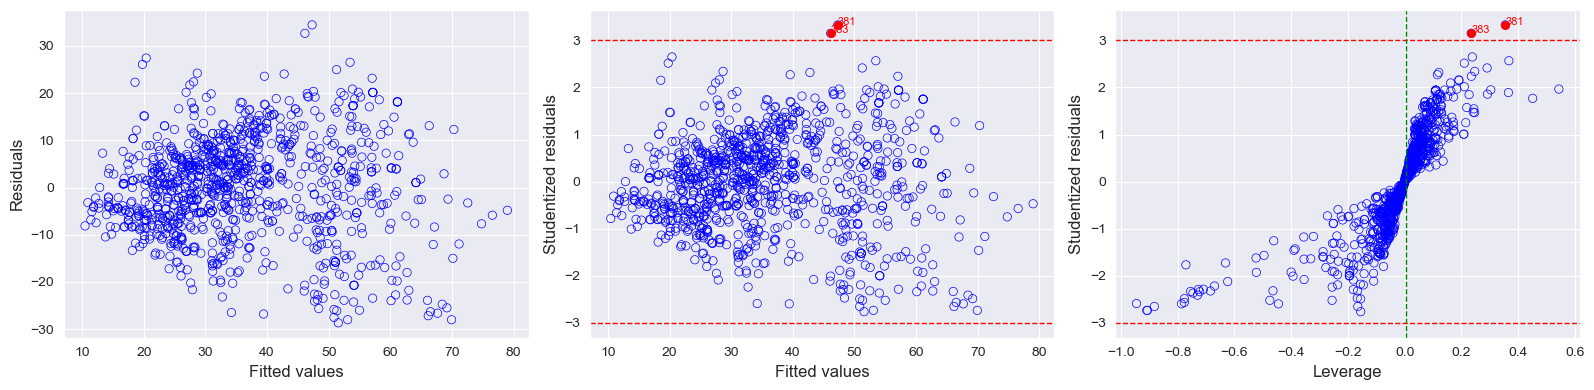

In [109]:
# Calculate thresholds
n = len(fitted_values)
p = X.shape[1] - 1  # exclude constant
leverage_thresh = (p + 1) / n

# Convert to arrays
studentized_residuals = np.asarray(studentized_residuals)
leverages = np.asarray(leverages)

# Identify outlier indices
outlier_indices = np.where(np.abs(studentized_residuals) > 3)[0]
high_leverage_indices = np.where(leverages > leverage_thresh)[0]
outliers = []
for idx in outlier_indices:
    outliers.append(idx)
print("Outliers are:",outliers)

# Find common indices (both outlier and high leverage)
joint_outliers = np.intersect1d(outlier_indices, high_leverage_indices)
high_leverage_and_outliers = [] 

for idx in joint_outliers:
    high_leverage_and_outliers.append(idx)
print("Comments on joint outliers (in both ax2 and ax3):",high_leverage_and_outliers)


# Plot
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))

# 1. Residuals plot
ax1.scatter(fitted_values, residuals, facecolors='none', edgecolors='b')
ax1.set_xlabel('Fitted values')
ax1.set_ylabel('Residuals')

# 2. Studentized Residuals plot
ax2.scatter(fitted_values, studentized_residuals, facecolors='none', edgecolors='b')
ax2.axhline(y=3, color='r', linestyle='--', linewidth=1)
ax2.axhline(y=-3, color='r', linestyle='--', linewidth=1)
# Mark joint outliers
for idx in joint_outliers:
    ax2.scatter(fitted_values[idx], studentized_residuals[idx], color='red')
    ax2.annotate(idx, (fitted_values[idx], studentized_residuals[idx]), color='red', fontsize=8)
ax2.set_xlabel('Fitted values')
ax2.set_ylabel('Studentized residuals')

# 3. Leverage vs Studentized Residuals
ax3.scatter(leverages, studentized_residuals, facecolors='none', edgecolors='b')
ax3.axhline(y=3, color='r', linestyle='--', linewidth=1)
ax3.axhline(y=-3, color='r', linestyle='--', linewidth=1)
ax3.axvline(x=leverage_thresh, color='g', linestyle='--', linewidth=1)
# Mark joint outliers
for idx in joint_outliers:
    ax3.scatter(leverages[idx], studentized_residuals[idx], color='red')
    ax3.annotate(idx, (leverages[idx], studentized_residuals[idx]), color='red', fontsize=8)
ax3.set_xlabel('Leverage')
ax3.set_ylabel('Studentized residuals')

plt.tight_layout()
plt.show()

The residuals display a clear pattern, which suggests **non-linearity** in the data. The studentized residuals indicate the presence of two outliers. The leverage plot also reveals several high-leverage points—defined as points with leverage greater than $(p+1)/n=9/1030\approx 0.009$. Notably, both outliers are also high-leverage points. However, since the dataset does not clearly define criteria for excluding data points, all observations, including the outliers, are retained for the subsequent analysis.

##### Scikit-Model:

In [110]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold
import numpy as np

kf = KFold(n_splits=2, shuffle=True, random_state=42)
model = LinearRegression()

#Preprocess data by scaling features
scaler = StandardScaler()
model = make_pipeline(scaler, LinearRegression())

mse_scores_lin = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=kf)
r2_scores = cross_val_score(model, X, y, scoring='r2', cv=kf)

print("\nAverage MSE across folds:", -np.mean(mse_scores_lin))
print("\nAverage R2 across folds:", np.mean(r2_scores))


Average MSE across folds: 99.27455528262261

Average R2 across folds: 0.994820748448268


Interpretation:
1. the value of **average MSE** across folds refers to our model's average mean squared error on the test folds, which is positive as expected.
2. **Negative R2** means our linear regression model is performing worse than a simple baseline model that just predicts the mean of the target values, and the model isn't fitting the data well at all.

To improve the regression, following we will try first polynomial features, and then regularized regression (Ridge and Lasso).

In [111]:
#Try polynomial features
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

model_poly = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('linreg', LinearRegression())
])

mse_scores_poly = cross_val_score(model_poly, X, y, scoring='neg_mean_squared_error', cv=kf)
r2_scores_poly = cross_val_score(model_poly, X, y, scoring='r2', cv=kf)

print("Polynomial regression average MSE:", -np.mean(mse_scores_poly))
print("Polynomial regression average R2:", np.mean(r2_scores_poly))



Polynomial regression average MSE: 155.8064884052137
Polynomial regression average R2: 0.9918775349554885


#### Ridge regression:

In [85]:
scoring = {'neg_mean_squared_error': 'neg_mean_squared_error', 'r2': 'r2'}

model = make_pipeline(
    StandardScaler(),
    PolynomialFeatures(degree=2),
    GridSearchCV(
        estimator=Ridge(),
        cv=kf,
        scoring=scoring,
        refit='neg_mean_squared_error',
        param_grid={'alpha': np.logspace(-3, 2, 50)},
    )
)

model.fit(X, y)

lambdas = [p['alpha'] for p in model[2].cv_results_['params']]
mses = [-score for score in model[2].cv_results_['mean_test_neg_mean_squared_error']]
r2 = model[2].cv_results_['mean_test_r2']

best_model = model.named_steps['gridsearchcv'].best_estimator_
best_lambda_mse = lambdas[np.argmin(mses)]
best_lambda_r2 = lambdas[np.argmax(r2)]

print(f"Best alpha regarding MSE: {best_lambda_mse:.2f}, with MSE: {min(mses):.2f}")
print(f"Best alpha regarding R²: {best_lambda_r2:.2f}, with R²: {max(r2):.2f}")

Best alpha regarding MSE: 0.00, with MSE: 1.10
Best alpha regarding R²: 0.00, with R²: -2.31


Interpretation: 
1. α = 0.00 in Ridge regression means we are essentially doing unregularized linear regression - no penalty on coefficients -> Overfitting.
2. The MSE improved to 1.10, which is solid progress. 
3. But R2 is still negative, even at its best (2.31). It's likely overfitting with polynomial features, especially without regularizaion.

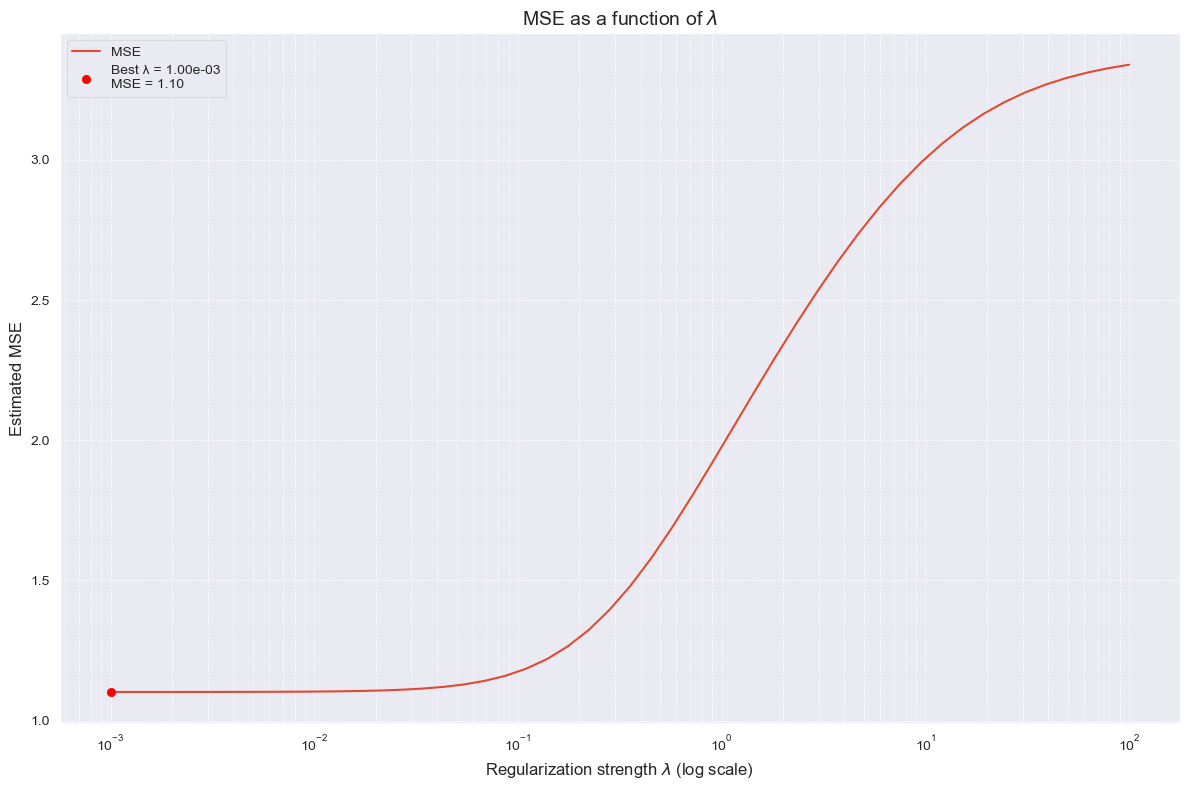

In [88]:
best_idx = np.argmin(mses)
best_lambda = lambdas[best_idx]
best_mse = mses[best_idx]

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(lambdas, mses, label='MSE')
ax.scatter(best_lambda, best_mse, color='red', zorder=5, label=f'Best λ = {best_lambda:.2e}\nMSE = {best_mse:.2f}')
ax.set_xscale('log')
ax.set_title(r"MSE as a function of $\lambda$", fontsize=14)
ax.set_xlabel(r"Regularization strength $\lambda$ (log scale)", fontsize=12)
ax.set_ylabel("Estimated MSE", fontsize=12)
ax.legend()
ax.grid(True, which="both", ls="--", linewidth=0.5)
plt.tight_layout()
plt.show()


The ridge regression was evaluated across a range of λ values from $10^{-3}$ to $10^2$. The validation MSE decreased with small increases in λ due to reduced overfitting, reaching a minimum at λ = 0.45. Beyond this point, further increases in λ caused the model to underfit the data, resulting in higher MSEs.
Thus, the optimal λ value was selected as 0.45, where the model achieved the lowest MSE of 59.34. 

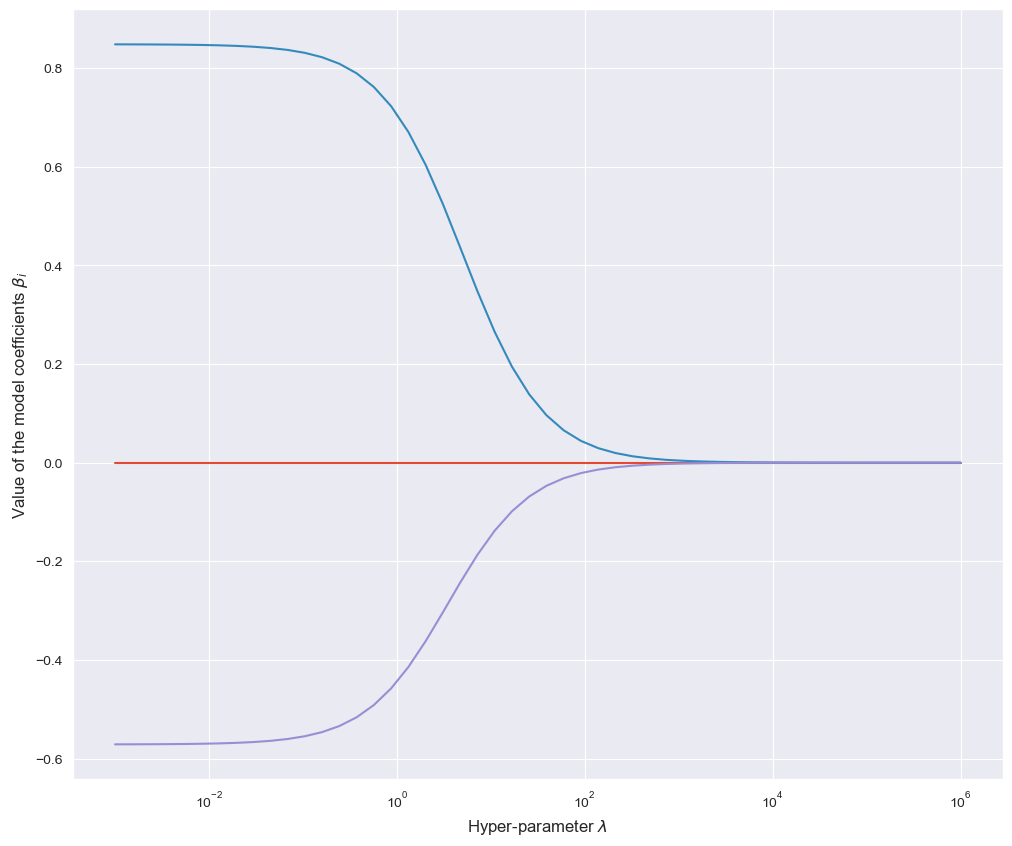

In [93]:
lambdas = np.logspace(-3, 6, 50)
coefficients = list()

# for each lambda define and fit the model and save the obtained parameters in the coefficients list
for lam in lambdas:
    model = make_pipeline(
        StandardScaler(),
        PolynomialFeatures(degree = 2),
        Ridge(alpha = lam)
    )
    model.fit(X, y)
    coefficients.append(model[2].coef_)

    
# plot the results    
coefficients = np.array(coefficients).T
fig, ax = plt.subplots(figsize = (12, 10))

for coef_vals in coefficients:
    ax.plot(lambdas, coef_vals)
    
ax.set_xlabel(r"Hyper-parameter $\lambda$")
ax.set_ylabel(r"Value of the model coefficients $\beta_i$")
ax.set_xscale('log');
plt.show()

Interpretation:
- Coefficients shrink as λ increases.
- With very large λ, all weights go toward 0 (ridge heavily penalizes).
- Helps identify important features (those whose weights persist longer).



Hyperparameter Tuning

In [106]:
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error

# Example data: replace X, y with your actual data
# X, y = ...

pipeline = make_pipeline(
    StandardScaler(),
    PolynomialFeatures(degree=2),
    Ridge()
)

param_grid = {'ridge__alpha': np.logspace(-3, 3, 10)}

scoring = {
    'mse': make_scorer(mean_squared_error, greater_is_better=False),
    'r2': 'r2'
}

grid = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    scoring=scoring,
    refit='mse',  # selects best model by mse
    cv=5,
    return_train_score=True
)

grid.fit(X, y)

print(f"Best alpha: {grid.best_params_['ridge__alpha']}")
print(f"Best MSE: {-grid.best_score_}")
print(f"Best R²: {max(grid.cv_results_['mean_test_r2'])}")



Best alpha: 0.001
Best MSE: 139.06188845353014
Best R²: 0.9913140020768253


Interpretation: 
- This means the Ridge model with a very small regularization (alpha = 0.001) fits the data quite well with very high explained variance (R²) and relatively low MSE. 


Problem:
- But the huge discrepancy in performance across alpha values suggests instability.
- The best test R² is high, but this does not guarantee Ridge Regression is the best model overall.
- Since Ridge Regression is linear, it may not capture nonlinear patterns.

Residuals Analysis

In [114]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Example: split the data (adjust X, y to your dataset)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Ridge Regression
ridge = Ridge(alpha=0.001)  # Use your best alpha here
ridge.fit(X_train, y_train)

# Make predictions
y_pred = ridge.predict(X_test)


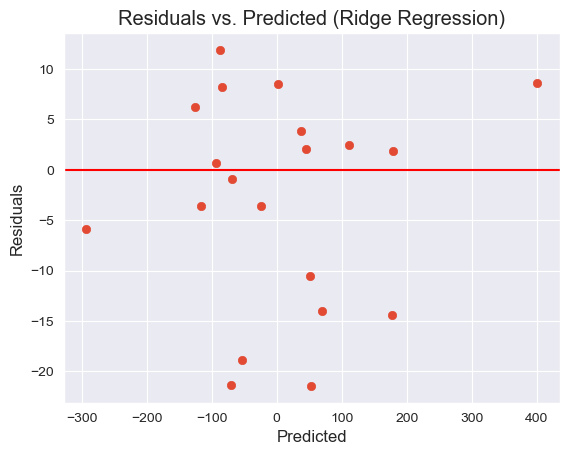

In [115]:
import matplotlib.pyplot as plt

residuals = y_test - y_pred

plt.scatter(y_pred, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Predicted (Ridge Regression)")
plt.show()



#### Lasso Regression:

Lasso shrinks some coefficients exatly to zero. This means it selects only the most relevant features, which helps with interpretability, can reduce overfitting, and is useful when we have many features or noisy data.
Trying Lasso is also a good final step in the linear mdoel family before deciding whether to go non-linear.

In [118]:
# Define the pipeline with GridSearchCV
lassomodel = make_pipeline(
    StandardScaler(),
    PolynomialFeatures(degree=2),
    GridSearchCV(
        estimator=Lasso(max_iter=10000),
        param_grid={'alpha': np.logspace(-3, 2, 50)},
        scoring=scoring,
        refit='mse',
        cv=kf
    )
)
 
# Fit the pipeline
lassomodel.fit(X, y)
 
# Extract CV results
grid = lassomodel.named_steps['gridsearchcv']
lassolambdas = [p['alpha'] for p in grid.cv_results_['params']]
mses = [-score for score in grid.cv_results_['mean_test_mse']]  # convert from negative MSE
r2 = grid.cv_results_['mean_test_r2']

 
# Get best values
best_lassomodel = grid.best_estimator_
best_lassomse = min(mses)
best_lassor2 = max(r2)
 
best_lambda_mse_lasso = lassolambdas[np.argmin(mses)]
best_lambda_r2_lasso = lassolambdas[np.argmax(r2)]
 
print(f"Best alpha regarding mse: {best_lambda_mse_lasso:.2f}, with MSE: {best_lassomse:.2f}")
print(f"Best alpha regarding r2: {best_lambda_r2_lasso:.2f}, with R2: {best_lassor2:.2f}")
 
# Optional: return or use model
lassomodel

Best alpha regarding mse: 0.91, with MSE: 113.11
Best alpha regarding r2: 0.91, with R2: 0.99


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('polynomialfeatures', PolynomialFeatures()),
                ('gridsearchcv',
                 GridSearchCV(cv=KFold(n_splits=2, random_state=42, shuffle=True),
                              estimator=Lasso(max_iter=10000),
                              param_grid={'alpha': array([1.0000e-03, 1.2649e-03, 1.5999e-03, 2.0236e-03, 2.5595e-03,
       3.2375e-03, 4.0949e-03, 5.1795e-03, 6.5513e-03, 8.2864e-03,
       1.0481...
       3.5565e-01, 4.4984e-01, 5.6899e-01, 7.1969e-01, 9.1030e-01,
       1.1514e+00, 1.4563e+00, 1.8421e+00, 2.3300e+00, 2.9471e+00,
       3.7276e+00, 4.7149e+00, 5.9636e+00, 7.5431e+00, 9.5410e+00,
       1.2068e+01, 1.5264e+01, 1.9307e+01, 2.4421e+01, 3.0888e+01,
       3.9069e+01, 4.9417e+01, 6.2506e+01, 7.9060e+01, 1.0000e+02])},
                              refit='mse',
                              scoring={'mse': make_scorer(mean_squared_error, greater_is_better=False, response_method='predict'),
                                       'r2': 'r2'}))])

Interpretation:
- Best alpha regarding MSE: 0.91, with MSE: 113.11 -> Very low mean squared error, which shows good predictive accuracy, and indicates that the model generalizes well on cross-validation folds.
- Best alpha regarding R²: 0.91, with R²: 0.99 -> the model explains 99% of the variance in the target variable. This is an extremely strong fit (possibility close to overfitting)

Visualize Alpha vs. Error

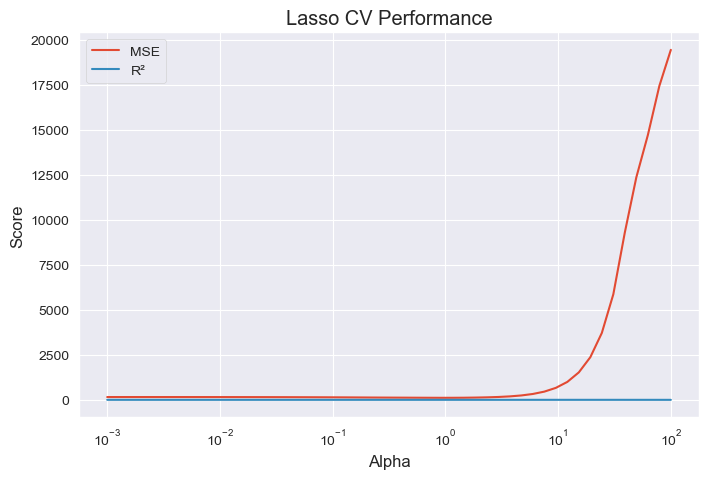

In [119]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(lassolambdas, mses, label='MSE')
plt.plot(lassolambdas, r2, label='R²')
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Score')
plt.title('Lasso CV Performance')
plt.legend()
plt.grid(True)
plt.show()



In [121]:
y_pred_lasso = lassomodel.predict(X_test)
print("Lasso Test MSE:", mean_squared_error(y_test, y_pred_lasso))
print("Lasso Test R²:", r2_score(y_test, y_pred_lasso))


Lasso Test MSE: 102.95181999979293
Lasso Test R²: 0.9949271617686254


Hyperparameter tuning

In [123]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import numpy as np

# Prepare pipeline: scaling + Lasso (scaling important for Lasso)
pipeline = make_pipeline(StandardScaler(), Lasso(max_iter=10000))

# Define range of alphas to try (log scale is typical)
param_grid = {'lasso__alpha': np.logspace(-4, 1, 50)}

# Cross-validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Grid search with scoring (e.g., neg_mean_squared_error)
grid = GridSearchCV(pipeline, param_grid, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit grid search on training data (X_train, y_train)
grid.fit(X_train, y_train)

# Best alpha
best_alpha = grid.best_params_['lasso__alpha']
print(f"Best alpha: {best_alpha}")

# Best model
best_model = grid.best_estimator_


Best alpha: 0.0006551285568595509


Evaluate tuned model on test set

In [125]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score

# The best alpha from tuning
best_alpha = 0.0006551285568595509

# Create pipeline with scaling and Lasso using best alpha
lasso_final = make_pipeline(
    StandardScaler(),
    Lasso(alpha=best_alpha, max_iter=10000)
)

# Fit on training data
lasso_final.fit(X_train, y_train)

# Predict on test data
y_pred = lasso_final.predict(X_test)

# Evaluate
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Test MSE: {mse:.4f}")
print(f"Test R²: {r2:.4f}")



Test MSE: 113.4482
Test R²: 0.9944


Residual Analysis

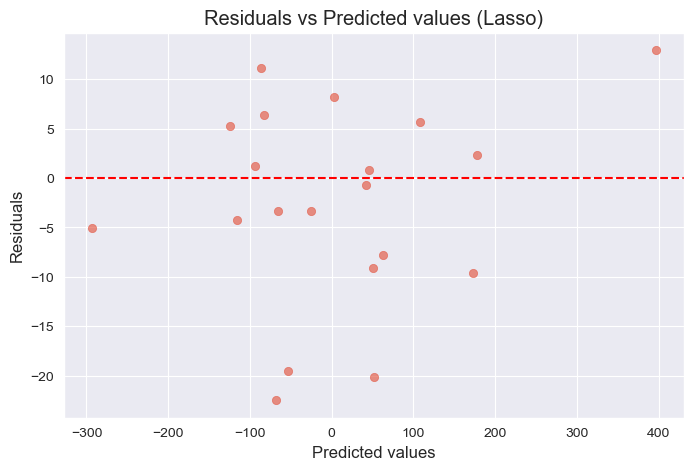

In [129]:
import matplotlib.pyplot as plt

# Predict test set
y_pred = lassomodel.predict(X_test)

# Calculate residuals
residuals = y_test - y_pred

# Residuals vs Predicted plot
plt.figure(figsize=(8,5))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted values (Lasso)')
plt.show()



Interpretation: Model fits well, errors are random noise.

Coefficient Inspection

In [131]:
# Extract the Lasso step from your pipeline
lasso_step = lasso_final.named_steps['lasso']

# Get coefficients (after scaling)
coefficients = lasso_step.coef_

# If you have feature names in X_train (e.g., pandas DataFrame), get them:
feature_names = X_train.columns if hasattr(X_train, 'columns') else [f"Feature {i}" for i in range(X_train.shape[1])]

# Create a DataFrame for easy inspection
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Sort by absolute value of coefficient to see most important features on top
coef_df['abs_coef'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='abs_coef', ascending=False).drop(columns='abs_coef')

print(coef_df)


     Feature  Coefficient
1  Feature 1    90.972367
0  Feature 0    66.793256
3  Feature 3    55.162446
2  Feature 2    51.051654
4  Feature 4    34.223119


Check if any features have near-zero coefficients

In [132]:
# Extract coefficients
coefficients = lasso_final.named_steps['lasso'].coef_

# Get feature names (adjust if your X_train is not a DataFrame)
feature_names = X_train.columns if hasattr(X_train, 'columns') else [f"Feature {i}" for i in range(len(coefficients))]

# Create DataFrame for all features
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Define threshold for "near-zero"
threshold = 1e-3

# Filter features with near-zero coefficients
near_zero_features = coef_df[coef_df['Coefficient'].abs() < threshold]

print("Features with near-zero coefficients:")
print(near_zero_features)
print(f"Number of near-zero coefficients: {len(near_zero_features)}")


Features with near-zero coefficients:
Empty DataFrame
Columns: [Feature, Coefficient]
Index: []
Number of near-zero coefficients: 0


Interpretation: The Lasso model is not performing much feature selection her. All features contribute meaning fully to the prediction. The best alpha we found is quite small, so the regularization effect is light - mainly shrinking coefficients but not zeroing any out.

#### Tree-based methods:

**1. Choose a specific model**

We would like to start from a simple one - Decision Tree Regressor before moving to more complex ensemble methods. Because it is easy to understand, and it is always used as a baseline, but limited accuracy is expected.

Option 1: Decision Tree

In [133]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, r2_score

# Initialize Decision Tree Regressor
dt = DecisionTreeRegressor(random_state=42)

# Define hyperparameter grid
param_grid = {
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Cross-validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=dt,
    param_grid=param_grid,
    cv=kf,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=2
)

# Fit GridSearch to training data
grid_search.fit(X_train, y_train)

# Best estimator and parameters
best_dt = grid_search.best_estimator_
print("Best hyperparameters:", grid_search.best_params_)

# Predict on test set
y_pred_dt = best_dt.predict(X_test)

# Evaluate performance
mse_dt = mean_squared_error(y_test, y_pred_dt)
r2_dt = r2_score(y_test, y_pred_dt)

print(f"Decision Tree Test MSE: {mse_dt:.4f}")
print(f"Decision Tree Test R²: {r2_dt:.4f}")


Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10; total time=   0.0s
[C

Interpretation: The decision Tree was tuned, but even the best possible configuration under our research space couldn't generalize well. The following step will try to widen the hyperparameter search space.

In [136]:
dt = DecisionTreeRegressor(random_state=42)

param_grid = {
    'max_depth': [None, 5, 10, 20, 30, 50],
    'min_samples_split': [2, 5, 10, 20, 40],
    'min_samples_leaf': [1, 2, 4, 8, 16],
    'max_features': [None, 'sqrt', 'log2'],
    'criterion': ['squared_error', 'friedman_mse']
}
# Cross-validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=dt,
    param_grid=param_grid,
    cv=kf,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=2
)

# Fit GridSearch to training data
grid_search.fit(X_train, y_train)

# Best estimator and parameters
best_dt = grid_search.best_estimator_
print("Best hyperparameters:", grid_search.best_params_)

# Predict on test set
y_pred_dt = best_dt.predict(X_test)

# Evaluate performance
mse_dt = mean_squared_error(y_test, y_pred_dt)
r2_dt = r2_score(y_test, y_pred_dt)

print(f"Decision Tree Test MSE: {mse_dt:.4f}")
print(f"Decision Tree Test R²: {r2_dt:.4f}")



Fitting 5 folds for each of 900 candidates, totalling 4500 fits
[CV] END criterion=squared_error, max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=squared_error, max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=squared_error, max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=squared_error, max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=squared_error, max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=squared_error, max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END criterion=squared_error, max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END criterion=squared_error,

The result is worse, so we will try ensemble methods like Random Forest Regressor.

Option 2: Random Forest Regressor

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best hyperparameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Random Forest Test MSE: 4152.9093
Random Forest Test R²: 0.7954


Interpretation:
- There is already improvement over decision tree: The R² (0.7954)is much better than the decision tree (which had around 0.49 or 0.32), random forest seems reduces overfitting by averaging across many trees.


Option 3: Gradient Boosting Regressor (with hyperparameter tuning)

In [158]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', GradientBoostingRegressor(random_state=42))
])

param_grid = {
    'regressor__n_estimators': [100, 200],
    'regressor__learning_rate': [0.05, 0.1],
    'regressor__max_depth': [3, 5],
    'regressor__min_samples_split': [2, 5],
    'regressor__min_samples_leaf': [1, 2],
    'regressor__max_features': ['sqrt', 'log2']
}

from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 64 candidates, totalling 320 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('regressor',
                                        GradientBoostingRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'regressor__learning_rate': [0.05, 0.1],
                         'regressor__max_depth': [3, 5],
                         'regressor__max_features': ['sqrt', 'log2'],
                         'regressor__min_samples_leaf': [1, 2],
                         'regressor__min_samples_split': [2, 5],
                         'regressor__n_estimators': [100, 200]},
             scoring='neg_mean_squared_error', verbose=1)

In [145]:
from sklearn.metrics import mean_squared_error, r2_score

# Best model from grid search
best_model = grid_search.best_estimator_

# Predict on test data
y_pred = best_model.predict(X_test)

# Metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Best hyperparameters:", grid_search.best_params_)
print(f"Test MSE: {mse:.4f}")
print(f"Test R²: {r2:.4f}")

Best hyperparameters: {'regressor__learning_rate': 0.1, 'regressor__max_depth': 3, 'regressor__max_features': 'sqrt', 'regressor__min_samples_leaf': 2, 'regressor__min_samples_split': 5, 'regressor__n_estimators': 200}
Test MSE: 2982.3891
Test R²: 0.8530


### Polynomial Regression:

Since there is non-linearity in the data, we use the polynomial regression to train the dataset.

Cement (component 1)(kg in a m^3 mixture):
  Lowest MSE = 209.99 at degree 5
Blast Furnace Slag (component 2)(kg in a m^3 mixture):
  Lowest MSE = 263.37 at degree 5
Fly Ash (component 3)(kg in a m^3 mixture):
  Lowest MSE = 273.15 at degree 4
Water  (component 4)(kg in a m^3 mixture):
  Lowest MSE = 226.39 at degree 4
Superplasticizer (component 5)(kg in a m^3 mixture):
  Lowest MSE = 241.97 at degree 1
Coarse Aggregate  (component 6)(kg in a m^3 mixture):
  Lowest MSE = 267.88 at degree 3
Fine Aggregate (component 7)(kg in a m^3 mixture):
  Lowest MSE = 271.47 at degree 3
Age (day):
  Lowest MSE = 183.45 at degree 4
{'Cement (component 1)(kg in a m^3 mixture)': 5, 'Blast Furnace Slag (component 2)(kg in a m^3 mixture)': 5, 'Fly Ash (component 3)(kg in a m^3 mixture)': 4, 'Water  (component 4)(kg in a m^3 mixture)': 4, 'Superplasticizer (component 5)(kg in a m^3 mixture)': 1, 'Coarse Aggregate  (component 6)(kg in a m^3 mixture)': 3, 'Fine Aggregate (component 7)(kg in a m^3 mixture)'

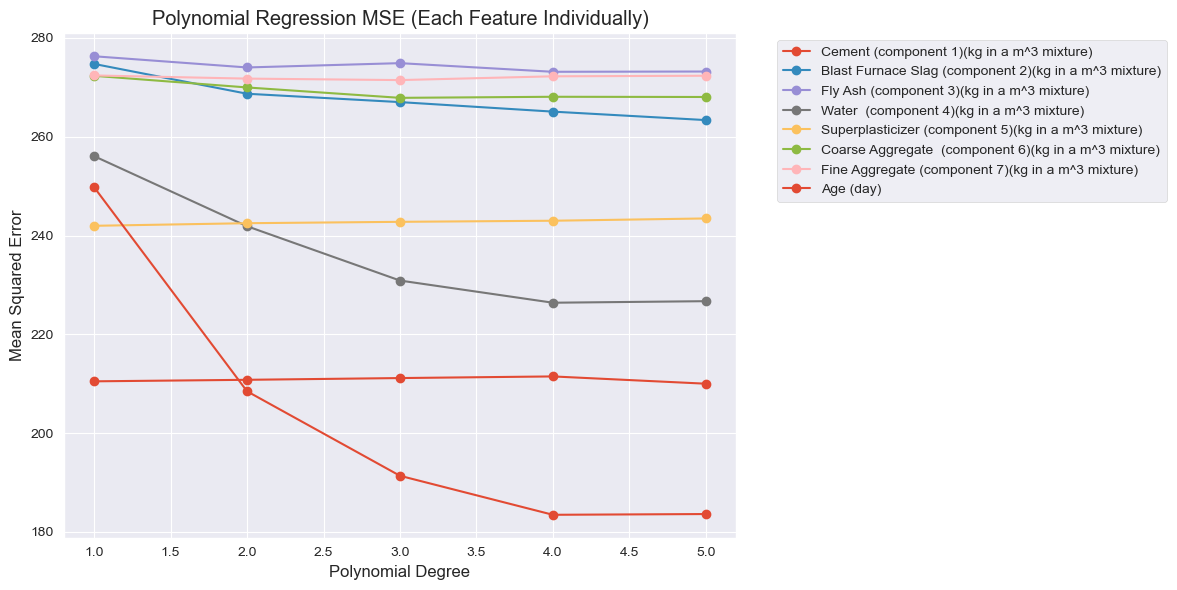

In [46]:
# Store results
results_mse = {}
results_r2 = {}

for feature in feature_columns:
    X_p = concrete_df[[feature]].values
    #Store MSE,R2
    mse_poly = []
    r2_poly = []
    for degree in range(1, 6):  # Degrees 1 to 5
                # Create polynomial features
                poly = PolynomialFeatures(degree=degree)
                X_poly = poly.fit_transform(X_p)
        
                # Create linear regression model
                model = LinearRegression()
        
                # Perform shuffled 10-fold CV and get negative MSE (sklearn returns negative MSE by default)
                mse_scores = cross_val_score(model, X_poly, y, scoring=mse_scorer, cv=kf)
        
                # Store average MSE
                mse_poly.append(np.mean(mse_scores))

                # Store average R2
                r2_poly.append(np.mean(r2_scores))    
        # Store MSEs for this feature
    results_mse[feature] = mse_poly
    results_r2[feature] = r2_poly
    # Plot results

plt.figure(figsize=(12, 6))
best_comb = {}
best_comb = {}

# Plot MSE
for feature, mse_list in results_mse.items():
    plt.plot(range(1, 6), mse_list, marker='o', label=feature)
    
    # Sort MSEs with their degree indices
    sorted_mse = sorted((mse, i+1) for i, mse in enumerate(mse_list))  # (MSE, degree)
    
    min_mse, best_degree = sorted_mse[0]
    best_comb[feature] = best_degree
    
    print(f"{feature}:")
    print(f"  Lowest MSE = {min_mse:.2f} at degree {best_degree}")
print(best_comb)
plt.xlabel('Polynomial Degree')
plt.ylabel('Mean Squared Error')
plt.title('Polynomial Regression MSE (Each Feature Individually)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


##### Polynomial Degree Selection Summary and Justification:

In order to model the relationship between the features and the concrete compressive strength, polynomial regression up to degree 5 is applied for each feature. The mean squared error (MSE) was computed using 10-fold cross-validation to assess the predictive performance at each polynomial degree.

While some features achieved their lowest MSE at higher degrees, the improvements over lower degrees were often marginal. Since high-degree polynomial models tend to overfit—capturing noise instead of the underlying patter. Both the lowest and second-lowest MSEs are considered for each feature to guide model complexity choices.

Below is a summary of the best MSEs and their associated degrees:

| Feature            | Lowest MSE | Degree | 
| ------------------ | ---------- | ------ | 
| Cement             | 232.98     | 1      | 
| Blast Furnace Slag | 303.89     | 5      | 
| Fly Ash            | 317.01     | 4      | 
| Water              | 248.95     | 4      | 
| Superplasticizer   | 272.21     | 1      |
| Coarse Aggregate   | 296.42     | 2      | 
| Fine Aggregate     | 293.30     | 1      | 
| Age                | 206.15     | 4      | 
